# 보험료에 영향을 미치는 요인

이 데이터세트에는 1,338행의 미국의 보험 데이터가 포함되어 있으며 보험 요금은 보험 가입자의 연령, 성별, BMI, 아동 수, 흡연자 및 지역 속성에 따라 제공된다.

속성은 숫자형 변수와 범주형 변수가 혼합되어 있습니다.

데이터 세트에 결측치는 포함되어 있지 않다.

> https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset

| 변수 | 의미 | 기타 |
|---|---|---|
| age | 수익자의 연령 | 수치형 |
| sex | 계약자의 성별 | 범주형 데이터(female/male) |
| bmi | 미만도. 몸무게를 키의 제곱으로 나눈 값. | 수치형<br/>정상범위: 18.5~24.9 |
| children | 의료보험이 적용되는 자녀 수 | 수치형 데이터 |
| smoker | 흡연 여부 | 범주형 데이터(yes/no) |
| region | 거주지역 | 범주형<br/>(북동: northeast, 남동: southeast / 남서: southwest / 북서: northwest) |
| charges | 의료비 | 수치형 데이터 |

## #01. 준비작업

### [1] 패키지 참조

In [98]:
%%time

import sys
import os
work_path = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(work_path)

from helper.regrassion import *
from helper.util import *
from helper.plot import *
from helper.analysis import *

from sklearn.preprocessing import PolynomialFeatures
from pandas import DataFrame, merge

CPU times: total: 0 ns
Wall time: 0 ns


### [2] 데이터 가져오기

In [76]:
%%time
categories = ["sex", "smoker", "region"]
origin = my_read_excel("https://data.hossam.kr/mldata/us_health_insurance.xlsx", categories=categories)
my_read

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB
None

데이터프레임 상위 5개 행
+----+-------+--------+--------+------------+----------+-----------+-----------+
|    |   age | sex    |    bmi |   children | smoker   | region    |   charges |
|----+-------+--------+--------+------------+----------+-----------+-----------|
|  0 |    19 | female |   27.9 |          0 | yes      | southwest |   16884.9 |
|  1 |    18 | male   |  33.77 |          1 | no       | southeast |   1725.55 |
|  2 |    28 | male   |     33 |          3 

NameError: name 'my_read' is not defined

> 연속형 변수인 age, bmi, children은 데이터 분포가 상이하므로 스케일링을 수행해야 한다. 
>
> 명목형 변수는 흡연 여부를 제외하고는 대체로 데이터가 균형잡혀 있다. 명목형에 대한 특별한 데이터 처리는 불필요할 것으로 보인다.
>
> 의료비지출 변수의 통계값을 살펴보면 중앙값이 `$9,382`이고, 평균이 `$13,270`인 것을 알 수 있다. 여기서 해당 변수의 평균값이 중앙값보다 크기 때문에 의료비 분포는 오른쪽으로 꼬리가 긴 분포를 지닐 것이다.

## #02. 탐색적 데이터 분석

### [1] 연속형 변수에 대한 데이터 분포

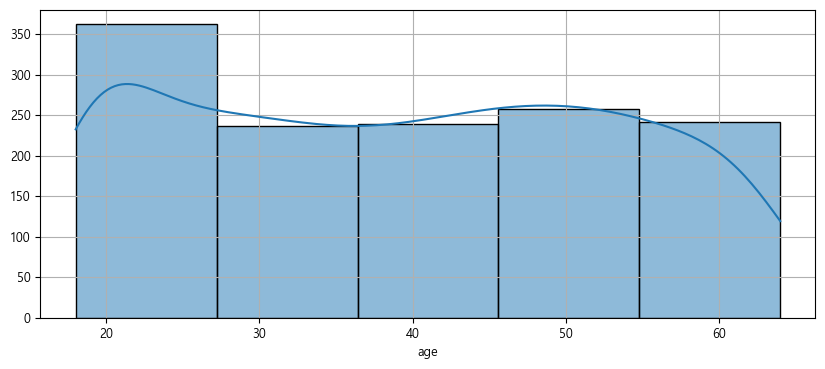

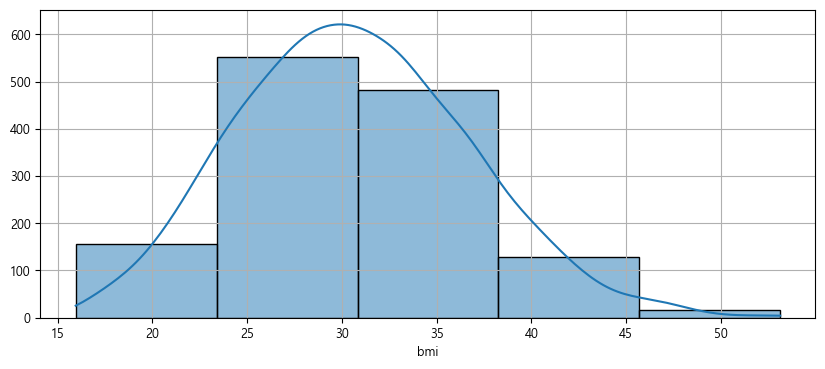

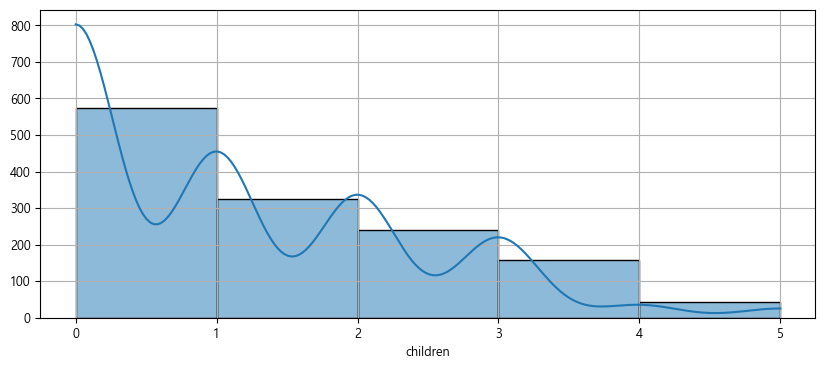

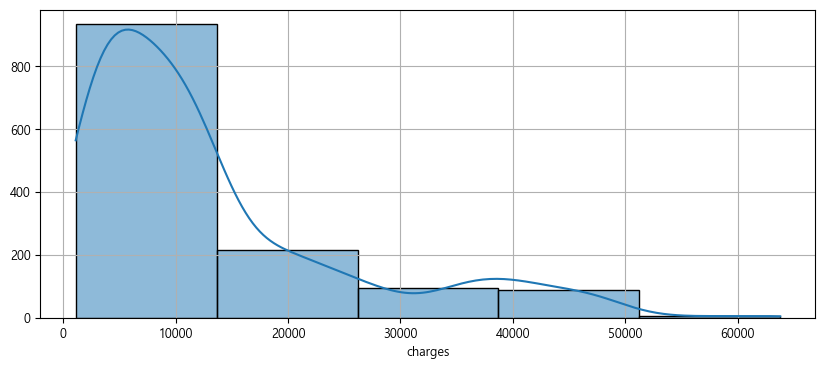

In [77]:
for c in ['age', 'bmi', 'children', 'charges']:
    my_histplot(origin, c, bins=5, dpi=100)

> 대부분의 사람들은 연간 $15,000 이하의 의료비 지출에 분포되어 있음을 알 수 있다.
> 
> 마찬가지로 bmi지수를 살펴보면 과체중이상의 데이터가 절반 이상을 차지하는 것을 알 수 있다.

### [2] 각 변수간의 관계 파악

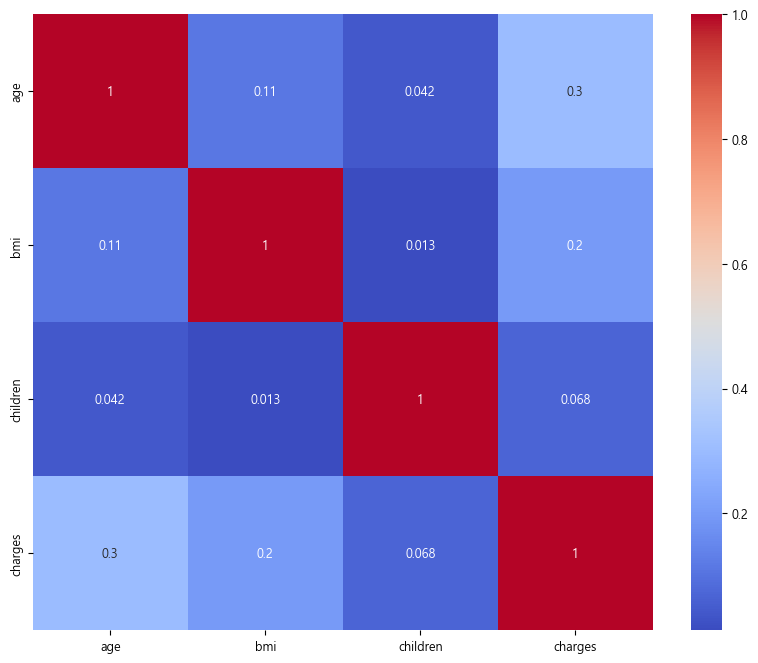

+-------------------------+---------------+-------------+----------+
|                         |   correlation |     p-value | result   |
|-------------------------+---------------+-------------+----------|
| ('age', 'bmi')          |      0.109272 | 6.19429e-05 | True     |
| ('age', 'children')     |      0.042469 |    0.120493 | False    |
| ('age', 'charges')      |      0.299008 | 4.88669e-29 | True     |
| ('bmi', 'age')          |      0.109272 | 6.19429e-05 | True     |
| ('bmi', 'children')     |     0.0127589 |     0.64101 | False    |
| ('bmi', 'charges')      |      0.198341 | 2.45909e-13 | True     |
| ('children', 'age')     |      0.042469 |    0.120493 | False    |
| ('children', 'bmi')     |     0.0127589 |     0.64101 | False    |
| ('children', 'charges') |     0.0679982 |   0.0128521 | True     |
| ('charges', 'age')      |      0.299008 | 4.88669e-29 | True     |
| ('charges', 'bmi')      |      0.198341 | 2.45909e-13 | True     |
| ('charges', 'children') |     0.

In [78]:
my_correlation(origin[['age', 'bmi', 'children', 'charges']], dpi=100)

> 연령, bmi지수, 부양가족 수, 의료비지출은 약하지만 모두 양(+)의 상관관계를 보이고 있다.
>
> 예를 들어, 연령과 bmi지수는 나이가 들어갈 수록 몸무게가 증가되면서 bmi 지수가 높아지는 경향을 설명할 수 있고, 부양가족 수가 증가하면 의료비 지출이 많아진다고 보는 것도 합리적인 판단이 될 수 있다.

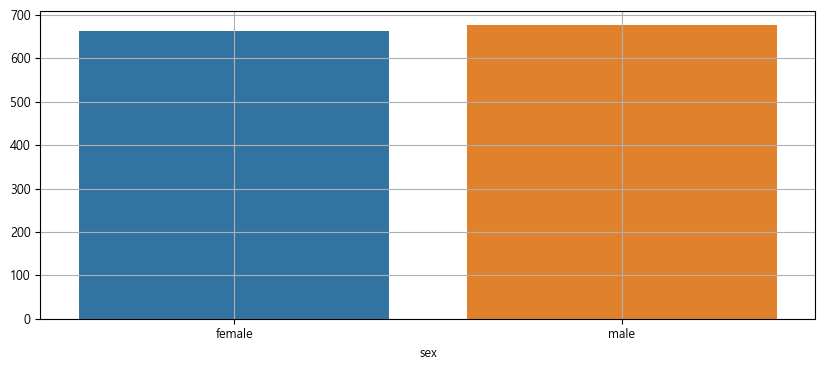

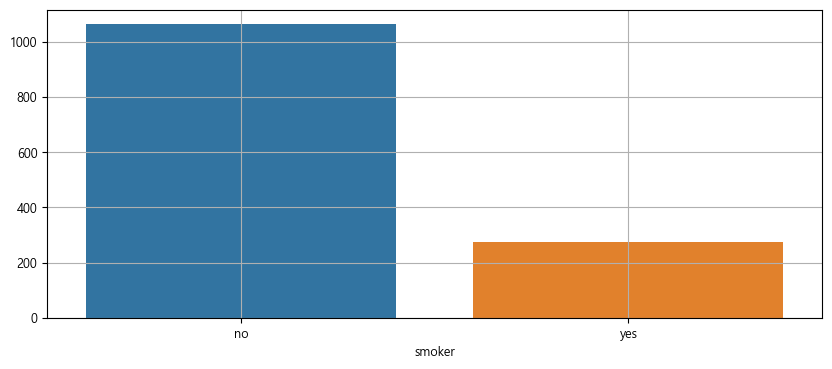

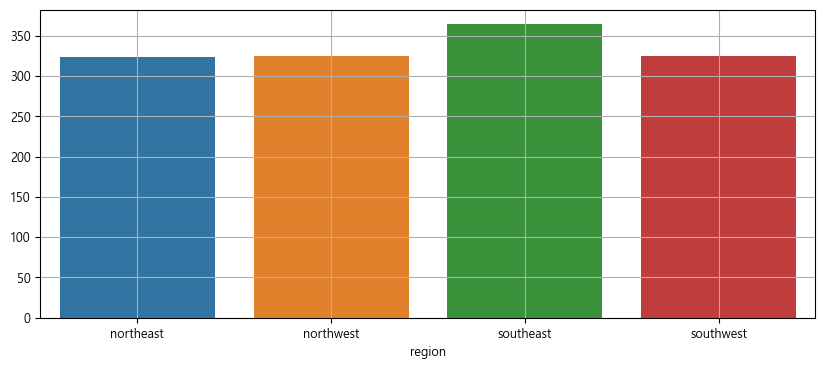

In [79]:
for c in categories:
    my_countplot(origin, c, dpi=100)

> 흡연 여부의 경우 비흡연자가 많이 분포되어 있다.
> 
> 그 밖에 성별과 지역의 경우 비슷하게 분포되어 있기 때문에 분산분석을 통해 통제요인으로 넣는 것을 고려해 볼 수 있겠다.

### [3] 분산분석을 통한 통제요인 선정

In [80]:
from helper.analysis import my_anova

for c in categories:
    tmp = origin[[c, 'charges']]
    my_anova(tmp, hue=c, target='charges')

pingouin.anova
+----+----------+-------------+------+------------+--------+-----------+------------+
|    | Source   |          SS |   DF |         MS |      F |     p-unc |        np2 |
|----+----------+-------------+------+------------+--------+-----------+------------|
|  0 | sex      |  6.4359e+08 |    1 | 6.4359e+08 | 4.3997 | 0.0361327 | 0.00328238 |
|  1 | Within   | 1.95431e+11 | 1336 | 1.4628e+08 |    nan |       nan |        nan |
+----+----------+-------------+------+------------+--------+-----------+------------+

statsmodels.anova.anova_lm
+----------+------+-------------+------------+--------+-----------+
|          |   df |      sum_sq |    mean_sq |      F |    PR(>F) |
|----------+------+-------------+------------+--------+-----------|
| C(sex)   |    1 |  6.4359e+08 | 6.4359e+08 | 4.3997 | 0.0361327 |
| Residual | 1336 | 1.95431e+11 | 1.4628e+08 |    nan |       nan |
+----------+------+-------------+------------+--------+-----------+
[anova_lm] statistic: 4.400, p-va

In [81]:
tmp = origin[["sex", "smoker", "region", "charges"]]
my_anova(tmp, target="charges", hue=["sex", "smoker", "region"])

pingouin.anova
+----+-----------------------+-------------+------+-------------+------------+--------------+-------------+
|    | Source                |          SS |   DF |          MS |          F |        p-unc |         np2 |
|----+-----------------------+-------------+------+-------------+------------+--------------+-------------|
|  0 | sex                   | 4.99724e+06 |    1 | 4.99724e+06 |  0.0910793 |     0.762857 | 6.88903e-05 |
|  1 | smoker                | 1.19401e+11 |    1 | 1.19401e+11 |    2176.19 | 1.25108e-281 |    0.622091 |
|  2 | region                | 1.05877e+08 |    3 | 3.52923e+07 |   0.643235 |     0.587268 |  0.00145756 |
|  3 | sex * smoker          | 4.10428e+08 |    1 | 4.10428e+08 |    7.48043 |   0.00632067 |  0.00562658 |
|  4 | sex * region          | 1.38228e+06 |    3 |      460760 | 0.00839778 |     0.998944 | 1.90566e-05 |
|  5 | smoker * region       | 1.32965e+09 |    3 | 4.43218e+08 |    8.07805 |  2.46961e-05 |   0.0180014 |
|  6 | sex * 

> 성별과 흡연량, 흡연량과 지역 간에는 교효작용 효과가 있음이 발견되었다.

### [4] 교효작용에 대한 시각화 확인

#### (1) 흡연 여부에 따른 성별 분포

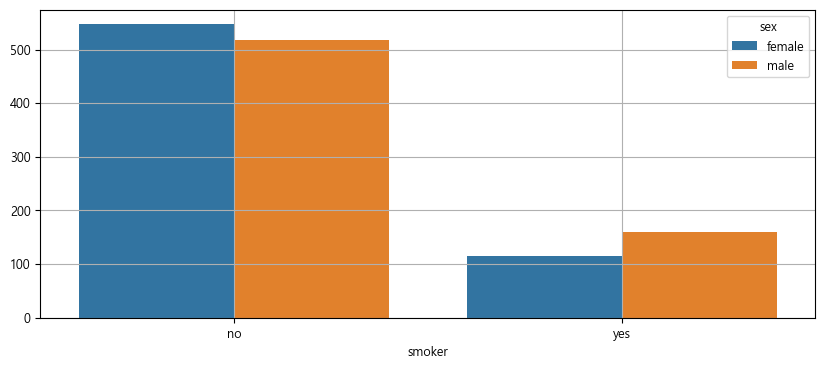

In [82]:
my_countplot(origin, xname="smoker", hue='sex', dpi=100)

#### (2) 흡연 여부에 따른 지역 분포

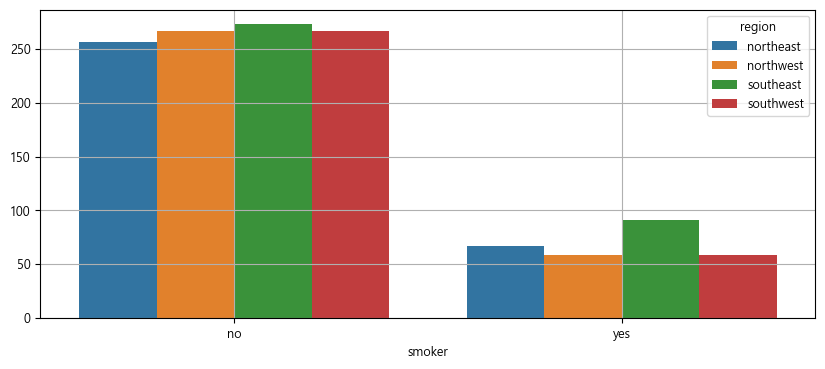

In [83]:
my_countplot(origin, xname="smoker", hue='region', dpi=100)

## #03. 데이터 전처리

### [1] 데이터 표준화 

In [84]:
std_df = my_standard_scaler(origin, yname="charges")
my_pretty_table(std_df.head())

+----+-----------+-----------+------------+--------+----------+-----------+-----------+
|    |       age |       bmi |   children | sex    | smoker   | region    |   charges |
|----+-----------+-----------+------------+--------+----------+-----------+-----------|
|  0 |  -1.43876 |  -0.45332 |  -0.908614 | female | yes      | southwest |   16884.9 |
|  1 |  -1.50997 |  0.509621 | -0.0787672 | male   | no       | southeast |   1725.55 |
|  2 | -0.797954 |  0.383307 |    1.58093 | male   | no       | southeast |   4449.46 |
|  3 | -0.441948 |  -1.30553 |  -0.908614 | male   | no       | northwest |   21984.5 |
|  4 | -0.513149 | -0.292556 |  -0.908614 | male   | no       | northwest |   3866.86 |
+----+-----------+-----------+------------+--------+----------+-----------+-----------+


### [2] 더미변수 생성

In [85]:
dummy_df = my_dummies(origin)
my_pretty_table(dummy_df.head())

+----+-------+--------+------------+-----------+------------+--------------+--------------------+--------------------+--------------------+
|    |   age |    bmi |   children |   charges |   sex_male |   smoker_yes |   region_northwest |   region_southeast |   region_southwest |
|----+-------+--------+------------+-----------+------------+--------------+--------------------+--------------------+--------------------|
|  0 |    19 |   27.9 |          0 |   16884.9 |          0 |            1 |                  0 |                  0 |                  1 |
|  1 |    18 |  33.77 |          1 |   1725.55 |          1 |            0 |                  0 |                  1 |                  0 |
|  2 |    28 |     33 |          3 |   4449.46 |          1 |            0 |                  0 |                  1 |                  0 |
|  3 |    33 | 22.705 |          0 |   21984.5 |          1 |            0 |                  1 |                  0 |                  0 |
|  4 |    32 |  28.8

### [4] 훈련, 검증 데이터 분리

In [86]:
x_train, x_test, y_train, y_test = my_train_test_split(dummy_df, "charges", test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1070, 8), (268, 8), (1070,), (268,))

## #05. 선형회귀 분석

### [1] 전체 변수에 대한 분석

In [87]:
my_linear_regrassion(x_train, y_train, x_test, y_test, cv=5, dpi=100, use_plot=False, resid_test=False)

[교차검증]
+----+-------------------+
|    |   mean_test_score |
|----+-------------------|
|  0 |          0.732513 |
+----+-------------------+

[회귀식]
charges = 255.647 * age + 342.676 * bmi + 451.587 * children + -83.442 * sex_male + 23501.011 * smoker_yes + -419.220 * region_northwest + -1033.274 * region_southeast + -1026.348 * region_southwest + -11830.463

[회귀분석 성능평가]
+--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|        |   결정계수(R2) |   평균절대오차(MAE) |   평균제곱오차(MSE) |   평균오차(RMSE) |   평균 절대 백분오차 비율(MAPE) |   평균 비율 오차(MPE) |
|--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------|
| 데이터 |       0.800174 |              4013.1 |         3.05524e+07 |          5527.43 |                         41.0093 |              -20.7827 |
+--------+----------------+---------------------+--------------------

LinearRegression(n_jobs=-1)

### [2] bmi를 제외한 상태로 분석

In [88]:
ignore = ['bmi']
x_train2 = x_train.drop(ignore, axis=1)
x_test2 = x_test.drop(ignore, axis=1)

my_linear_regrassion(x_train2, y_train, x_test2, y_test, cv=5, dpi=100, use_plot=False, resid_test=False)

[교차검증]
+----+-------------------+
|    |   mean_test_score |
|----+-------------------|
|  0 |          0.706778 |
+----+-------------------+

[회귀식]
charges = 270.725 * age + 474.541 * children + 149.559 * sex_male + 23369.090 * smoker_yes + -399.319 * region_northwest + 383.019 * region_southeast + -722.646 * region_southwest + -2504.752

[회귀분석 성능평가]
+--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|        |   결정계수(R2) |   평균절대오차(MAE) |   평균제곱오차(MSE) |   평균오차(RMSE) |   평균 절대 백분오차 비율(MAPE) |   평균 비율 오차(MPE) |
|--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------|
| 데이터 |       0.773724 |              3931.3 |         3.45966e+07 |          5881.89 |                         32.8914 |              -20.7933 |
+--------+----------------+---------------------+---------------------+------------------

LinearRegression(n_jobs=-1)

### [3] children을 제외한 후 분석

In [89]:
ignore = ['bmi', 'children']
x_train2 = x_train.drop(ignore, axis=1)
x_test2 = x_test.drop(ignore, axis=1)

my_linear_regrassion(x_train2, y_train, x_test2, y_test, cv=5, dpi=100, use_plot=False, resid_test=False)

[교차검증]
+----+-------------------+
|    |   mean_test_score |
|----+-------------------|
|  0 |          0.704795 |
+----+-------------------+

[회귀식]
charges = 272.778 * age + 199.381 * sex_male + 23370.460 * smoker_yes + -343.994 * region_northwest + 392.585 * region_southeast + -650.862 * region_southwest + -2130.177

[회귀분석 성능평가]
+--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|        |   결정계수(R2) |   평균절대오차(MAE) |   평균제곱오차(MSE) |   평균오차(RMSE) |   평균 절대 백분오차 비율(MAPE) |   평균 비율 오차(MPE) |
|--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------|
| 데이터 |       0.770795 |             3970.02 |         3.50444e+07 |          5919.83 |                         34.6503 |               -22.007 |
+--------+----------------+---------------------+---------------------+------------------+--------------------

LinearRegression(n_jobs=-1)

> 대부분의 변수가 소거되어 훈련 모델의 신뢰도가 상당히 낮다. 다른 변수들을 추가로 투입해야 할 것 같다.

## #05. 탐색적 데이터 분석

도메인 지식이란 특정 분야의 전문화된 지식. (=노하우)

도메인 지식을 활용하면 도출된 분석모델의 성능을 개선할 수 있다.

### [1] 의료비 지출

일반적으로 의료비 지출에 대한 연령의 영향은 전 연령에 걸쳐 일정하지 않다.

20,30대와 50,60,70대 간의 의료비 지출 차이는 크게 날 수 밖에 없다.

기존의 연령 변수는 전형적인 선형회귀 방정식을 따른다.

$ y = ax + b $

하지만 고연령대일 수록 증가폭이 커지는 현상을 설명하기 위해서는 높은 차수의 항을 회귀 모델에 추가해서 다항식으로 만들어 주면 된다.

$ y = ax^2 + bx + c $

#### (1) 연령대 별 평균 의료비 확인

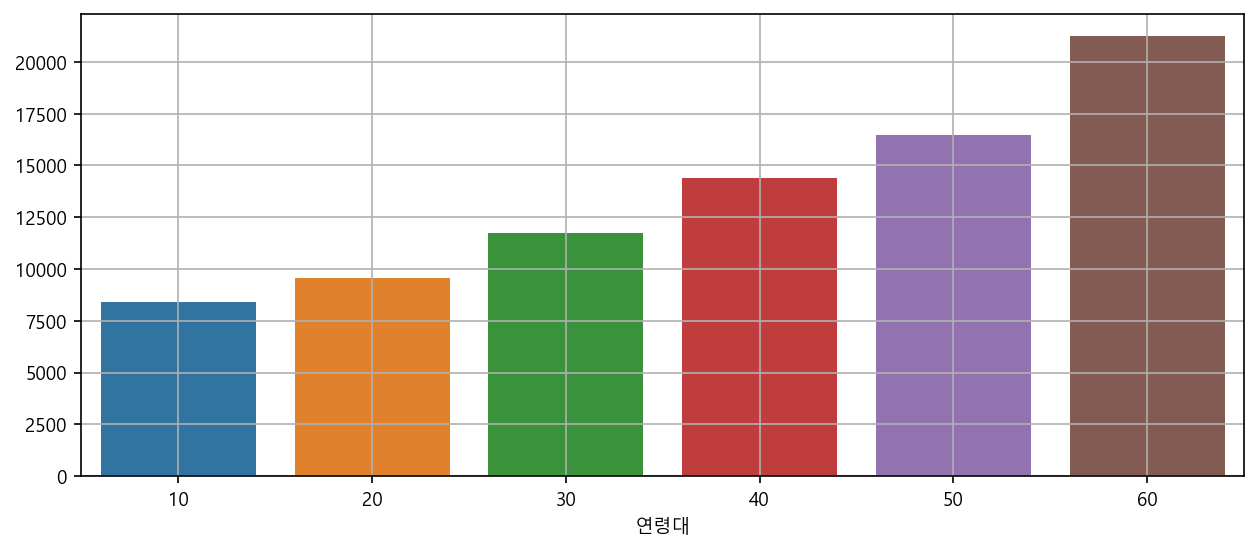

In [90]:
df  = origin.copy()
df['연령대'] = df['age'].apply(lambda x: int(x//10)*10)
mean_df = df.filter(['연령대', 'charges']).groupby('연령대').mean().reset_index()
my_barplot(mean_df, xname = '연령대', yname = 'charges')

> 고연령대일수록 증가폭이 커지고 있다는 것을 확인할 수 있다.

### (2) 나이에 대한 2차항 추가하기

#### 직접 구현하기

In [91]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_fit = poly.fit_transform(origin[["age"]])
poly_df = DataFrame(poly_fit, columns=poly.get_feature_names_out(), index=origin.index)

my_pretty_table(poly_df.head())

+----+-------+---------+
|    |   age |   age^2 |
|----+-------+---------|
|  0 |    19 |     361 |
|  1 |    18 |     324 |
|  2 |    28 |     784 |
|  3 |    33 |    1089 |
|  4 |    32 |    1024 |
+----+-------+---------+


In [96]:
new_df = origin.copy()
new_df[poly_df.columns] = poly_df[poly_df.columns]

my_pretty_table(new_df.head())

+----+-------+--------+--------+------------+----------+-----------+-----------+---------+
|    |   age | sex    |    bmi |   children | smoker   | region    |   charges |   age^2 |
|----+-------+--------+--------+------------+----------+-----------+-----------+---------|
|  0 |    19 | female |   27.9 |          0 | yes      | southwest |   16884.9 |     361 |
|  1 |    18 | male   |  33.77 |          1 | no       | southeast |   1725.55 |     324 |
|  2 |    28 | male   |     33 |          3 | no       | southeast |   4449.46 |     784 |
|  3 |    33 | male   | 22.705 |          0 | no       | northwest |   21984.5 |    1089 |
|  4 |    32 | male   |  28.88 |          0 | no       | northwest |   3866.86 |    1024 |
+----+-------+--------+--------+------------+----------+-----------+-----------+---------+


#### 모듈화 기능 활용

In [99]:
new_df = my_poly_features(origin, columns=['age'])
my_pretty_table(new_df.head())

+----+-------+--------+--------+------------+----------+-----------+-----------+---------+
|    |   age | sex    |    bmi |   children | smoker   | region    |   charges |   age^2 |
|----+-------+--------+--------+------------+----------+-----------+-----------+---------|
|  0 |    19 | female |   27.9 |          0 | yes      | southwest |   16884.9 |     361 |
|  1 |    18 | male   |  33.77 |          1 | no       | southeast |   1725.55 |     324 |
|  2 |    28 | male   |     33 |          3 | no       | southeast |   4449.46 |     784 |
|  3 |    33 | male   | 22.705 |          0 | no       | northwest |   21984.5 |    1089 |
|  4 |    32 | male   |  28.88 |          0 | no       | northwest |   3866.86 |    1024 |
+----+-------+--------+--------+------------+----------+-----------+-----------+---------+


### [2] 비만도 (BMI)

BMI는 특정 구간에서의 영향은 적지만 어느정도의 구간을 넘어가면 강한 영향을 미친다.

#### (1) 비만도에 따른 의료비 지출 차이 확인

In [100]:
new_df[['bmi','charges']]

,bmi,charges
0,27.900,16884.92400
1,33.770,1725.55230
2,33.000,4449.46200
3,22.705,21984.47061
4,28.880,3866.85520
...,...,...
1333,30.970,10600.54830
1334,31.920,2205.98080
1335,36.850,1629.83350
1336,25.800,2007.94500


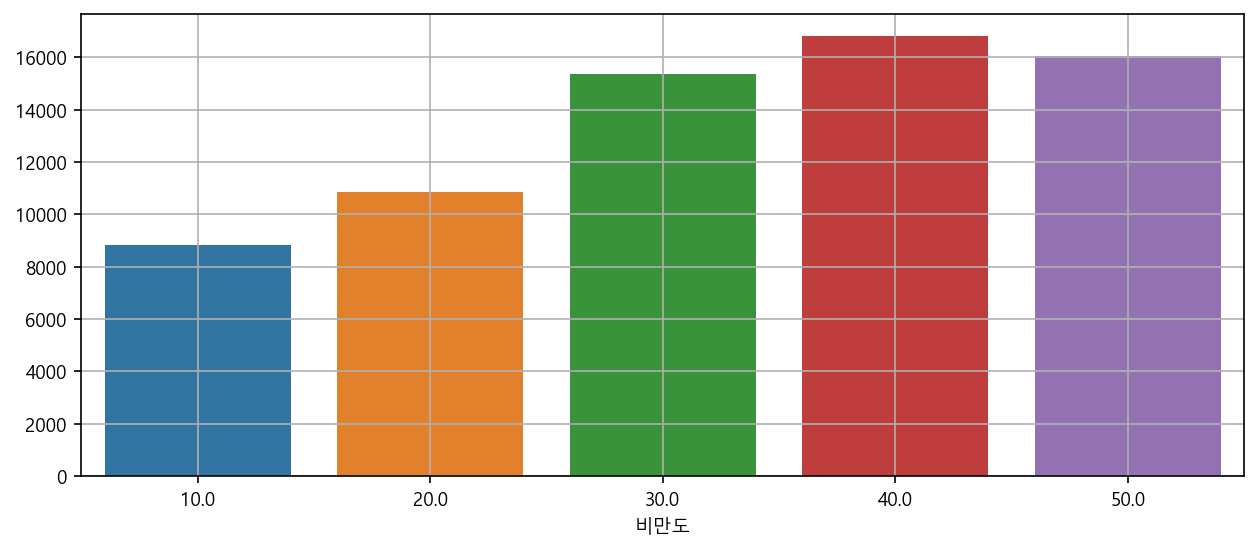

In [101]:
df  = new_df.copy()
df['비만도'] = df['bmi'].apply(lambda x: x//10*10)
mean_df = df.filter(['비만도', 'charges']).groupby('비만도').mean().reset_index()
my_barplot(mean_df, xname = '비만도', yname = 'charges')

> bmi값의 단위가 30 이상인 경우의 의료비 지출의 증가량이 그렇지 않은 경우보다 더 크다.
>
> 이 내용을 더미변수로 추가할 수 있다.

#### (2) 비만과 정상 체중에 대한 파생변수 추가

In [112]:
new_df['obesity'] = new_df['bmi'] >30
# new_df['obesity'] = new_df['obesity'].astype('int') # 기존 방식
new_df['obesity'] = new_df['obesity'].astype('uint8') # 표준화 수행을 위해 더미변수와 같은 타입으로 변경
new_df

,age,sex,bmi,children,smoker,region,charges,age^2,obesity
0,19.0,female,27.900,0,yes,southwest,16884.92400,361.0,0
1,18.0,male,33.770,1,no,southeast,1725.55230,324.0,1
2,28.0,male,33.000,3,no,southeast,4449.46200,784.0,1
3,33.0,male,22.705,0,no,northwest,21984.47061,1089.0,0
4,32.0,male,28.880,0,no,northwest,3866.85520,1024.0,0
...,...,...,...,...,...,...,...,...,...
1333,50.0,male,30.970,3,no,northwest,10600.54830,2500.0,1
1334,18.0,female,31.920,0,no,northeast,2205.98080,324.0,1
1335,18.0,female,36.850,0,no,southeast,1629.83350,324.0,1
1336,21.0,female,25.800,0,no,southwest,2007.94500,441.0,0


## #05. 파생변수가 추가된 상태에서의 회귀분석

나이에 대한 2차항이 추가되었으므로 다항선형회귀에 해당한다.

### [1] 더미변수 생성

In [113]:
df1 = my_dummies(new_df)
df1

,age,bmi,children,charges,age^2,obesity,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19.0,27.900,0,16884.92400,361.0,0,0,1,0,0,1
1,18.0,33.770,1,1725.55230,324.0,1,1,0,0,1,0
2,28.0,33.000,3,4449.46200,784.0,1,1,0,0,1,0
3,33.0,22.705,0,21984.47061,1089.0,0,1,0,1,0,0
4,32.0,28.880,0,3866.85520,1024.0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1333,50.0,30.970,3,10600.54830,2500.0,1,1,0,1,0,0
1334,18.0,31.920,0,2205.98080,324.0,1,0,0,0,0,0
1335,18.0,36.850,0,1629.83350,324.0,1,0,0,0,1,0
1336,21.0,25.800,0,2007.94500,441.0,0,0,0,0,0,1


In [114]:
df1.dtypes

age                 float64
bmi                 float64
children              int64
charges             float64
age^2               float64
obesity               uint8
sex_male              uint8
smoker_yes            uint8
region_northwest      uint8
region_southeast      uint8
region_southwest      uint8
dtype: object

### [2] 데이터 표준화

더미변수는 표준화 대상이 아니다.

In [122]:
# 수업
# df2 = my_standard_scaler(df1[['age', 'bmi', 'children', 'charges', 'age^2']], 'charges')
# my_pretty_table(df2.head())
# df3 = df1.copy()
# df3[df2.columns] = df2[df2.columns]
# my_pretty_table(df3.head())
# 이후 df3을 이용 
'위 방법으로 만든 df3와 아래방법으로 만든 df2은 동일하다'

df2 = my_standard_scaler(df1, 'charges')
my_pretty_table(df2.head())

+----+-----------+-----------+------------+-----------+-----------+------------+--------------+--------------------+--------------------+--------------------+-----------+
|    |       age |       bmi |   children |     age^2 |   obesity |   sex_male |   smoker_yes |   region_northwest |   region_southeast |   region_southwest |   charges |
|----+-----------+-----------+------------+-----------+-----------+------------+--------------+--------------------+--------------------+--------------------+-----------|
|  0 |  -1.43876 |  -0.45332 |  -0.908614 |  -1.22046 |         0 |          0 |            1 |                  0 |                  0 |                  1 |   16884.9 |
|  1 |  -1.50997 |  0.509621 | -0.0787672 |  -1.25334 |         1 |          1 |            0 |                  0 |                  1 |                  0 |   1725.55 |
|  2 | -0.797954 |  0.383307 |    1.58093 | -0.844579 |         1 |          1 |            0 |                  0 |                  1 |        

### [3] 훈련, 검증 데이터 분리

In [120]:
x_train, x_test, y_train, y_test = my_train_test_split(df2, 'charges', test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1070, 10), (268, 10), (1070,), (268,))

### [4] 다항선형회귀

[회귀식]
charges = 717.175 * children + 3671.012 * age^2 + 4201.530 * obesity + 23515.462 * smoker_yes + 6294.408

[회귀분석 성능평가]
+--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|        |   결정계수(R2) |   평균절대오차(MAE) |   평균제곱오차(MSE) |   평균오차(RMSE) |   평균 절대 백분오차 비율(MAPE) |   평균 비율 오차(MPE) |
|--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------|
| 데이터 |       0.804249 |             4012.69 |         2.99295e+07 |          5470.79 |                         42.4246 |              -21.6583 |
+--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+

[선형회귀분석 결과보고]
+----+------------+------------+--------------------+------------+------------------+--------+------------+---------+
|    | 종속변수   | 독립변수   |   B(비표준화 계수)

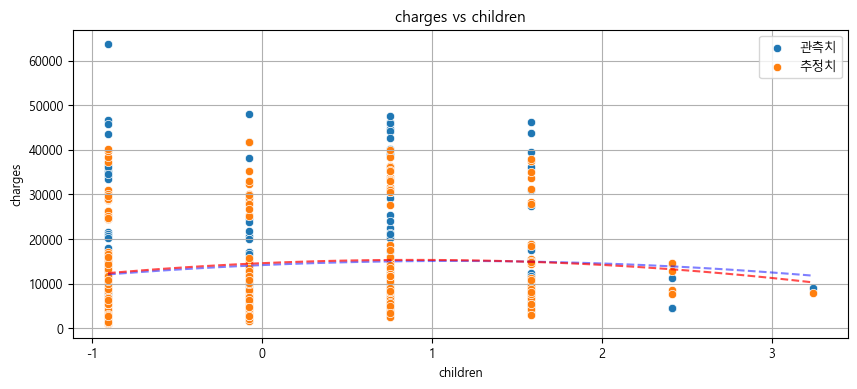

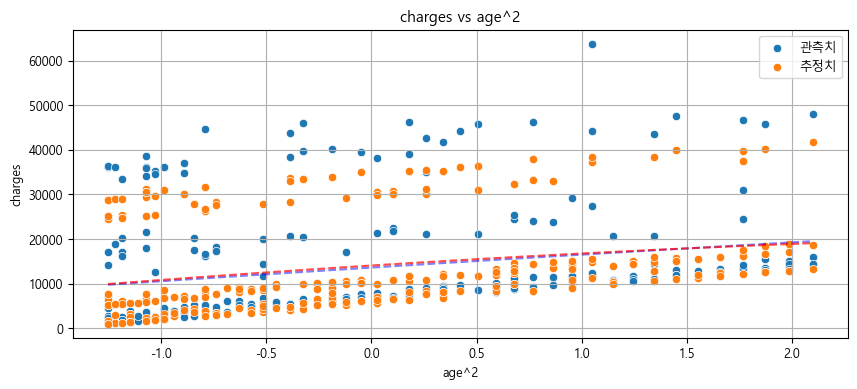

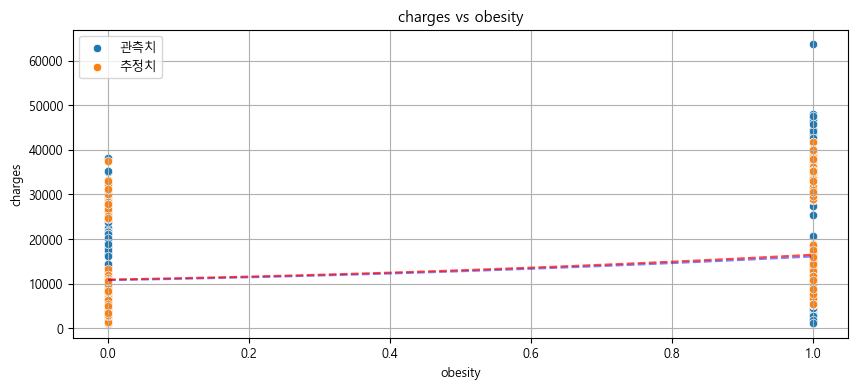

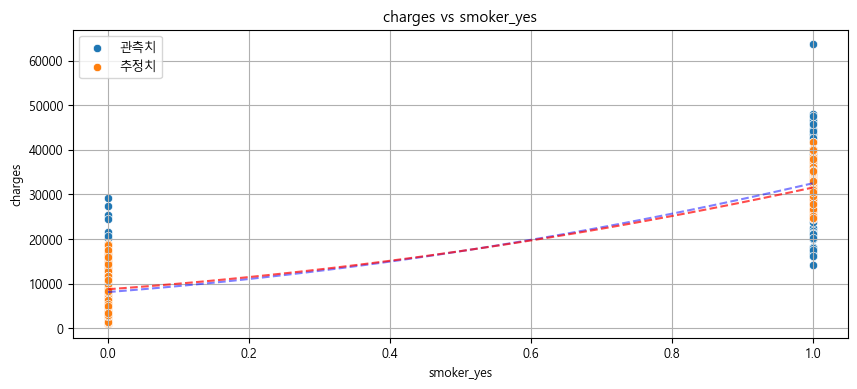

LinearRegression(n_jobs=-1)

In [119]:
ignore = ['age', 'bmi', 'region_northwest', 'region_southeast', 'region_southwest', 'sex_male']
x_train2 = x_train.drop(ignore, axis=1)
x_test2 = x_test.drop(ignore, axis=1)
my_linear_regrassion(x_train2, y_train, x_test2, y_test, degree=2, dpi=100)